# ABSTRACT
  
This tutorial will guide the user through the creation of population-weighted wealth maps and statistics for administrative areas of interest. After an explanation of micro-level wealth and population estimates, the user will learn to obtain this data for a country of interest alongside the boundaries for the country's administrative areas. These population and wealth data are next joined by location, aggregated to administrative areas, and the wealth data weighted by population. The user is finally guided through validation of their results and exporting the results as maps and tabular statistics. Throughout, the user will be introduced to widely useful Python packages and code as well as Google Earth Engine, a powerful tool for analyzing geographic and satellite imagery.  
     
<img src="img/poverty_maps_main_img.png" width="1500" align="center"/>  
  
# INTRODUCTION  
  
This tutorial is developed following the code and techniques developed by Emily Aiken and Joshua Blumenstock at the University of California, Berkeley. It provides an introduction to the data sources and code required to create population-weighted wealth measures and maps for any country or region of interest.    
    
## Introduction to Model-Derived Data Sources 
  
For policymakers and NGOs trying to assist the most vulnerable with limited resources, it is of primary importance to have an accurate view of their populations. Traditionally, surveys have been the only way to obtain this information, but the time and expense required for surveys - as well as the speed at which surveys can become outdated due to changing circumstances - make it challenging to identify all individuals in need.  
  
However, with the increasing prevelance of technologies which collect data at scale - including satellites, mobile phones, and WiFi - there are also emerging possibilities for the use of this data. Machine learning models, which can consider and make sense of data on a scale impossible for humans, are being used to combine these observational data with traditional survey responses to expand their usefulness: by providing a model data such as satellite imagery, phone networks, and wifi connectivity alongside ground-truth data collected by surveys, the model can learn what features best identify characteristics such as wealth and population to create predictions for other locations where survey information is unavailable.  
    
### Introduction to the Relative Wealth Indices  
  
For the wealth data component of this tutorial, we'll use an innovative geographic wealth dataset created from non-traditional sources. The [Relative Wealth Index](https://dataforgood.fb.com/tools/relative-wealth-index/) utilizes satellite imagery as well as mobile phone data, topographic maps, and Facebook connectivity data alongside wealth surveys to develop fine-grained (2.4km resolution) estimates of the relative standard of living within countries. Developed as part of a collaboration between UC Berkeley’s Center for Effective Global Action and Facebook’s Data for Good, these wealth estimates for 93 low and middle income countries are made freely available to aid in the work of policymakers and NGOs. See [Micro-Estimates of Wealth for all Low- and Middle-Income Countries](https://arxiv.org/abs/2104.07761) by Guanghua Chi, Han Fang, Sourav Chatterjee, and Joshua Blumenstock for details of the data creation and validation. Recent work such as [this](https://www.nber.org/system/files/working_papers/w29070/w29070.pdf) working paper by Emily Aiken, Suzanne Bellue, Dean Karlan, Christopher Udry, and Joshua Blumenstock demonstrate the value of such ML-derived wealth maps.  
  
<img src="img/rwi-facebook-img.PNG" width="600" align="center"/>  

### Introduction to Population Data  
  
To overcome the limitations of survey data, many are working to create comprehensive, granular, and accurate population estimates for countries across the globe. One such source is the [High Resolution Population Density Maps and Demographic Estimates](https://dataforgood.fb.com/docs/methodology-high-resolution-population-density-maps-demographic-estimates/), which was created as a collaboration between the Center for International Earth Science Information Network (CIESEN) at Columbia University and Facebook Data for Good. These provide estimates of relative population for most countries in the world at 30m resolution and are developed from satellite imagery and census data. 

<img src="img/pop-facebook-img.png" width="600" align="center"/> 

[WorldPop's](https://www.worldpop.org/) Population Count datasets are another source of nearly-global population data. WorldPop provides an entirely open-access collection of spatial demographic datasets for Central and South America, Asia, and Africa. There are multiple different [Population Count](https://www.worldpop.org/project/categories?id=3) datasets provided through WorldPop, with data for individual countries and globally available using either a `top-down` or `bottom-up` modelling approach. The `top-down` approach utilizes collected census data - typically at the level of a particular administrative area - and combines these with geospatial datasets to disaggregate population estimates at 100m or 1km resoultion. These have the benefit of rolling up to administrative level counts which match existing census counts, though countries without a recent census or countries with high mobility will likely have inaccuracies in these counts that will be reflected in the WorldPop estimates. The `bottom-up` approach instead uses all recent surveys available for an area alongside geospatial datasets to build estimated population counts at 100m resolution. These can provide greater accuracy where census data is outdated or where ground conditions are rapidly changing. For more information on the difference between top-down and bottom-up maps, see WorldPop's [explanation of the differences](https://www.worldpop.org/methods/populations). A final consideration if using the top-down estimates is whether to use data built with a `constrained` or `unconstrained` modelling approach. The `unconstrained` approach produces estimates over the entire land surface, while the `constrained` approach first limits its estimation to areas already mapped as containing settlements. The constrained approach can result in more accurate population allocation for areas of no population or high population as compared to the unconstrained approach, but it is dependent on accurate settlement mapping, which is not always available. For further discussion on the benefits and costs to using each method, see [WorldPop's explanation of the differences](https://www.worldpop.org/methods/populations). Compared to the High Resolution Population Density Maps described above, WorldPop's Population counts have the additional benefit of providing population data for different years, from 2000-2020. This can be useful if performing any historical analyses requiring population values. 
    
<img src="img/worldpop-img.png" width="600" align="center"/> 

### Introduction to Administrative Areas  
  
It is often the case that countries are governed and services provided according to hierarchical administrative areas. Recognizing and planning interventions around these areas is thus often useful and necessary for leaders both within and external to each country. There are a few organizations which aim to produce accurate, updated geographic datasets for administrative areas which are available for the use of researchers and policymakers. [GADM](https://gadm.org/) is one of the most comprehensive of these soruces, providing maps of all countries and associated sub-divisions. The Food and Agriculture Organization's (FAO's) Global Administrative Unit Layers ([FAO GAUL](https://data.apps.fao.org/map/catalog/srv/api/records/9c35ba10-5649-41c8-bdfc-eb78e9e65654)) also provides geographic boundaries for administrative units across many countries in the world, with the goal of creating an accurate, standardized source of historical and current administrative areas. 
  
<img src="img/fao-gaul-img.png" width="600" align="center"/> 

## Introduction to Geospatial Data and Tools
  
### Data Structure
In geospatial data analysis, data can be classified into two categories: raster and vector data. A graphic comparison between raster and vector data can be found in the World Bank [Nighttime Lights Tutorial module 2, section 1](https://worldbank.github.io/OpenNightLights/tutorials/mod2_1_data_overview.html).

* **Raster data**: Data stored in a raster format is arranged in a regular grid of cells, without storing the coordinates of each point (namely, a cell, or a pixel). The coordinates of the corner points and the spacing of the grid can be used to calculate (rather than to store) the coordinates of each location in the grid. Any given pixel in the grid stores one or more values (in one or more bands).
* **Vector data**: Data in a vector format is stored such that the X and Y coordinates are stored for each point. Data can be represented, for example, as points, lines and polygons. A point has only one coordinate (X and Y), a line has two or more coordinates, and a polygon is essentially a line that closes on itself to enclose a region. Polygons are usually used to represent the area and perimeter of continuous geographic features. Vector data stores features in their original resolution, without aggregation.

In this tutorial, we will use vector and raster data. Geospatial data in vector format are often stored in a **shapefile**, a popular format for storing vector data developed by ESRI. The **shapefile** format is actually composed of multiple individual files which make up the entire data. At a minimum, there will be 3 file types included with this geographic data (.shp, .shx, .dbf), but there are often other files included which store additional information. In order to be read and used as a whole, all file types must have the same name and be in the same folder. Because the structure of points, lines, and polygons are different, each shapefile can only contain one vector type (all points, all lines, or all polygons). You will not find a mixture of point, line, and polygon objects in a single shapefile, so in order to work with these different types in the same analysis, multiple shapefiles will need to be used and layered. For more details on shapefiles and file types, see [this documentation](https://desktop.arcgis.com/en/arcmap/latest/manage-data/shapefiles/shapefile-file-extensions.htm).  
    
Raster data, on the other hand, is stored in Tagged Image File Format (TIFF or TIF). A GeoTIFF is a TIFF file that follows a specific standard for structuring meta-data. The meta-data stored in a TIFF is called a tif tag and GeoTIFFs often contain tags including spatial extent, coordinate reference system, resolution, and number of layers.   
  
More information and examples can be found in sections 3 & 4 of the [Earth Analytics Course](https://www.earthdatascience.org/courses/earth-analytics/).  
  
### Python and Google Earth Engine for Earth Observation Data

One option we'll consider for sourcing administrative areas will be [Google Earth Engine](https://earthengine.google.com/). For all necessary Python setup and an introduction to our use of the GEE Python API, see the [World Bank Nighttime Light Tutorial](https://worldbank.github.io/OpenNightLights/tutorials/mod2_2_getting_started_with_Python.html), module 2 sections 2-5. In particular, before proceeding you will need to have `geemap` installed on your machine, and you will need to apply for a Google Earth Engine account [here](https://signup.earthengine.google.com/). **It may take a day or longer** for your Google Earth Engine account to be granted access.  
  
Two of the primary packages we'll be using, Pandas and GeoPandas, must be installed according to their installation instructions: [Pandas Installation](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html) and [GeoPandas Installation](https://geopandas.org/getting_started/install.html). If you're on Windows, GeoPandas installation can occasionally be temperamental - using an environment, as described in the World Bank Nighttime Lights Tutorial, can often circumvent any issues, but if you're still having problems, there are a number of guides online, such as this [Practial Data Science guide](https://www.practicaldatascience.org/html/gis_setup_geopandas.html) or this [Medium post](https://nayanemaia.medium.com/installing-geopandas-on-windows-aadd762c557c) by Nayane Maia, which provide installation help. Using [Windows Subsystem for Linux (WSL)](https://docs.microsoft.com/en-us/windows/python/web-frameworks) can also make use of tricky packages like GeoPandas easier.   
  
# POPULATION-WEIGHTED WEALTH MAPS  
  
For this tutorial, we'll demonstrate the process of creating population-weighted wealth estimates for all administrative levels in the country of Jordan. This process can be replicated for any country or region of interest, and the sources of data can be swapped as appropriate to use the most accurate sources of population, wealth, and administrative areas. 

## Data Ingestion  
  
### Relative Wealth Indices  
  
The relative wealth indices created by Chi et al., which we'll use in this tutorial, can be downloaded as `csv` files by country from the [Humanitarian Data Exchange](https://data.humdata.org/dataset/relative-wealth-index). To download, find the file associated with your country of interest ('Jordan_relative_wealth_index.csv' for this example) and select 'download'.   
  
<img src="img/rwi-download.png" width="600" align="center"/>   
  
Save the relative wealth index file in the same folder as this Python script is saved for easiest use. Once downloaded, we can read our file into Python using the `Pandas` Python package and convert it to geographic data using `GeoPandas`. `jor_relative_wealth_index.csv` is the `csv` file of Jordan downloaded from the Humanitarian Data Exchange - to utilize a different country's data, replace the file path with the path and name of your file. (Note: only the name of the file is included in this example because the csv file is in the same folder as this Python code. This is leveraging relative paths instead of absolute paths - for more information if you're unfamiliar with relative paths, see this [Earth Data Science tutorial](https://www.earthdatascience.org/courses/intro-to-earth-data-science/python-code-fundamentals/work-with-files-directories-paths-in-python/)).  

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
rwi = pd.read_csv('jor_relative_wealth_index.csv')

# Use latitude and longitude to create geographic points
rwi = gpd.GeoDataFrame(rwi, 
                       geometry=gpd.points_from_xy(rwi['longitude'], rwi['latitude']))
rwi.set_crs('epsg:4326',inplace=True)

,latitude,longitude,rwi,error,geometry
0,32.110495,35.804443,0.602,0.548,POINT (35.80444 32.11050)
1,31.700129,35.584717,0.454,0.555,POINT (35.58472 31.70013)
2,31.400535,35.716553,-0.189,0.498,POINT (35.71655 31.40053)
3,31.942840,35.848389,1.432,0.487,POINT (35.84839 31.94284)
4,32.184911,36.331787,0.464,0.549,POINT (36.33179 32.18491)
...,...,...,...,...,...
2782,32.685619,35.958252,0.103,0.564,POINT (35.95825 32.68562)
2783,30.817346,36.068115,-0.239,0.424,POINT (36.06812 30.81735)
2784,30.078601,35.211182,-0.258,0.544,POINT (35.21118 30.07860)
2785,31.475524,36.002197,-0.215,0.489,POINT (36.00220 31.47552)


We can see a snapshot of our relative wealth index in a tabular form above. We can view this data as a map using `matplotlib`, a Python package widely used for creating visualizations.

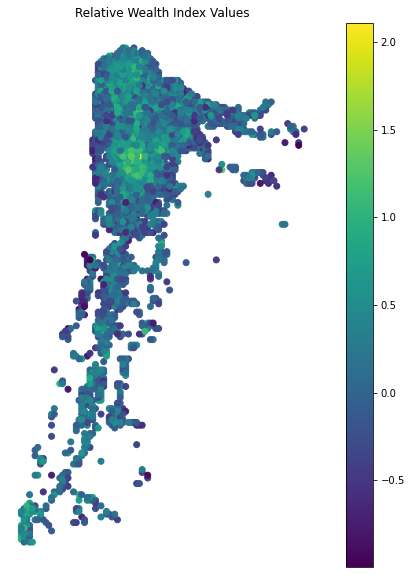

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,10))
# column='rwi' defines which column from our dataframe to color the points by
rwi.plot(ax=ax, column='rwi',legend=True)
ax.axis('off')
ax.set_title('Relative Wealth Index Values')
plt.show()

While we don't yet have a background map defining the country's borders, we can see the fine grain of the relative wealth index data in the map of Jordan above. The darker colors indicate the lowest wealth areas, relative to the rest of the country, while the yellow points represent the highest wealth areas.   

### Population Maps  
  
#### WorldPop

The population maps from WorldPop can be accessed via their [API](https://www.worldpop.org/sdi/introapi), which can enable greater reproducibility and ease of use especially if multiple datasets are needed. The `gather_worldpop_data()` function below will allow the user to access data from WorldPop via the API by simply selecting the desired WorldPop data (population for this example), country, and year they are interested in. However, if desired, the datasets can also be downloaded as GeoTIFF files from the [WorldPop website](https://www.worldpop.org/project/categories?id=3).   
  
You'll need to install the packages `requests`, which will allow us to use WorldPop's API to access the data, and `rioxarray`, which will allow us to read in the GeoTIFF file we download from WorldPop and convert it to a GeoPandas GeoDataFrame. To install these packages, follow their respective installation instructions: [requests Installation](https://docs.python-requests.org/en/master/user/install/#install) and [rioxarray Installation](https://corteva.github.io/rioxarray/stable/installation.html).

In [8]:
import requests
import rioxarray

def gather_worldpop_data(data_type, country_iso=None, year=2015):
    """
    Build the url to pull WorldPop data from the API

    Inputs:
        data_type (string): Data type options are 'pop' (population),
            'births', 'pregnancies', and 'urban_change'.capitalize
        country_iso (string): The 3-letter country code, if desired. Default
            will be global. 
        year (int): the 4-digit year of interest for data. Default will be
            2015.

    Return (str, rioxarray DataArray): returns the name of the .tif file
        downloaded onto your computer containing the data and the DataArray
        containing the population counts read in using rioxarray.
    """

    # Build the API url according to user selection
    url_base = "https://www.worldpop.org/rest/data"
    url = url_base + '/'  + data_type + '/wpgp'
    if country_iso:
        url = url + '?iso3=' + country_iso

    # Request the desired data; filter by year 
    json_resp = requests.post(url).json()
    json_resp = json_resp['data']['popyear' == year]
    # Obtain exact .geotiff file name for the desired data
    geotiff_file = json_resp['files'][0]
    print('Obtaining file',geotiff_file)

    geotiff_data = requests.get(geotiff_file)
    
    file_name = 'worldpop_' + country_iso + '_' + str(year) + '.tif'
    print('Writing to',file_name)
    with open(file_name,'wb') as f:
        f.write(geotiff_data.content)

    # Read in the WorldPop data as a GeoTIFF
    worldpop_raster = rioxarray.open_rasterio(file_name)

    return file_name, worldpop_raster

In [9]:
jordan_pop_file, jordan_pop = gather_worldpop_data('pop','JOR',2019)

Obtaining file https://data.worldpop.org/GIS/Population/Global_2000_2020/2000/JOR/jor_ppp_2000.tif
Writing to worldpop_JOR_2019.tif


We can now convert this data to a GeoDataFrame to be able to easily work with it in Python and join it with our other datasets. We'll do this according to the process described in [this stackoverflow post](https://gis.stackexchange.com/questions/358051/convert-raster-to-csv-with-lat-lon-and-value-columns/358057#358057).

In [3]:
jordan_pop = jordan_pop.squeeze().drop('spatial_ref').drop('band')
jordan_pop.name = 'population'
worldpop_pop_df = jordan_pop.to_dataframe().reset_index()
worldpop_pop_df.head()

,y,x,population
0,33.3675,34.957500,-99999.0
1,33.3675,34.958333,-99999.0
2,33.3675,34.959167,-99999.0
3,33.3675,34.960000,-99999.0
4,33.3675,34.960833,-99999.0


We now have our coordinates - latitude and longitude - along with the associated population values. We can see some data cleansing is needed to remove coordinates with no population value (denoted by -99999.0 population), and we'll also want to convert these coordinates into a geographic type we can use with GeoPandas.

In [4]:
# remove populations below 0
worldpop_pop_df = worldpop_pop_df[worldpop_pop_df['population'] > 0]
# convert lat/long to geometry
worldpop_pop_df['geometry'] = gpd.points_from_xy(worldpop_pop_df['x'], worldpop_pop_df['y'])

# convert to GeoDataFrame
worldpop_pop_gdf = gpd.GeoDataFrame(worldpop_pop_df)
worldpop_pop_gdf.head()

,y,x,population,geometry
4606,33.367500,38.795833,0.003340,POINT (38.79583 33.36750)
4607,33.367500,38.796667,0.003368,POINT (38.79667 33.36750)
9818,33.366667,38.794167,0.003384,POINT (38.79417 33.36667)
9819,33.366667,38.795000,0.003340,POINT (38.79500 33.36667)
9820,33.366667,38.795833,0.003384,POINT (38.79583 33.36667)


Excellent, we can now use this population data with our relative wealth values to create our population-weighted wealth estimates. As a final step, let's view these population values on a map.  
  
Warning: This is a very slow, intensive map to build due to the granularity of the population counts. This step is optional, so it can be skipped to conserve time or resources.

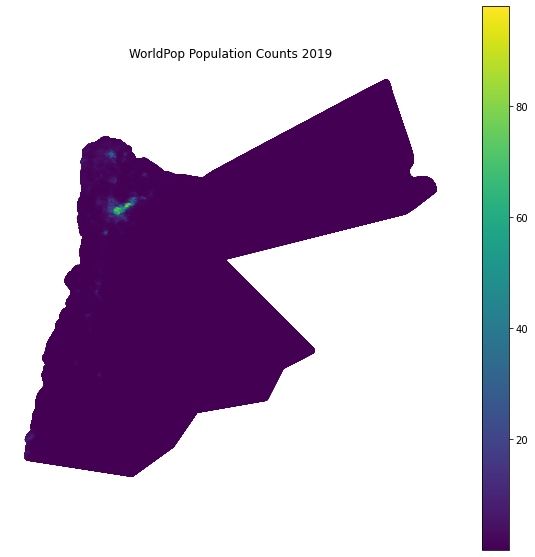

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# column='population' defines which column from our dataframe to color the points by
worldpop_pop_gdf.loc[:,('population','geometry')].plot(ax=ax, column='population',legend=True)
ax.axis('off')
ax.set_title('WorldPop Population Counts 2019')
plt.show()

#### Population Density Maps

Another option for population metrics are the High Resolution Population Density Maps from Columbia's CIESIN and Facebook's Data for Good. These can be downloaded from the [Humanitarian Data Exchange](https://data.humdata.org/dataset/jordan-high-resolution-population-density-maps-demographic-estimates) in either `GeoTIFF` or `csv` format: here, we'll demonstrate with the csv.  
  
To download, select download for the appropriate population `.csv.zip` from the Humanitarian Data Exchange site above:  
  
<img src="img/pop-hdx-download.PNG" width="600" align="center"/>  
  
Save this `.zip.csv` in the same folder as your Python script. You'll need to unzip this file to use it, which you can do by either right-clicking and selecting 'Extract All' (on Windows) or double-clicking (on MacOS). Once unzipped, we can ingest it here and begin using the population density values. 

In [4]:
pop = pd.read_csv('population_jor_2019-07-01.csv')
pop = gpd.GeoDataFrame(pop, geometry=gpd.points_from_xy(pop['Lon'], pop['Lat']))
pop.set_crs('epsg:4326',inplace=True)

,Lat,Lon,Population,geometry
0,32.557361,35.861806,17.355776,POINT (35.86181 32.55736)
1,32.554583,35.860139,17.355776,POINT (35.86014 32.55458)
2,32.557917,35.866806,17.355776,POINT (35.86681 32.55792)
3,32.557639,35.854583,17.355776,POINT (35.85458 32.55764)
4,32.572361,35.861528,17.355776,POINT (35.86153 32.57236)
...,...,...,...,...
877193,32.106806,35.795417,4.363106,POINT (35.79542 32.10681)
877194,32.110972,35.774583,4.363106,POINT (35.77458 32.11097)
877195,32.105694,35.781528,4.363106,POINT (35.78153 32.10569)
877196,32.091250,35.775694,4.363106,POINT (35.77569 32.09125)


We see we've successfully obtained population density values according to point locations, which we can also visualize as a map in the same way we've done above.  

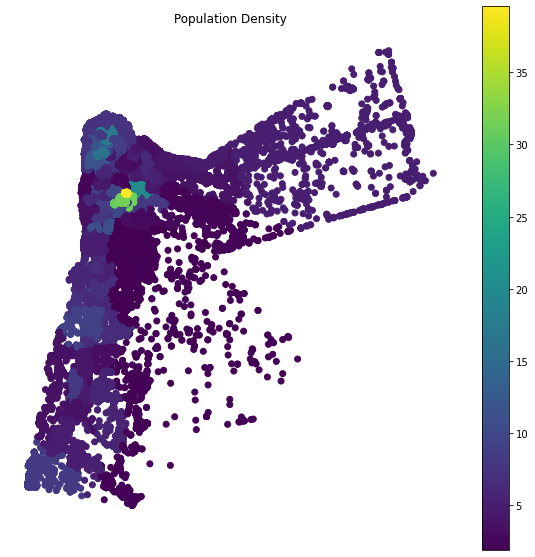

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# column='Population' identifies which column to use in coloring the points
pop.plot(ax=ax, column='Population',legend=True)
ax.axis('off')
ax.set_title('Population Density')
plt.show()

Either of these population data sources will allow you to create a population-weighted map of wealth, as will any other population data stored as a GeoDataFrame with a Point geometry and population values. To continue with this tutorial, regardless of your data source, simply ensure your data format matches the format in these examples.
    
### Note on Population and Wealth Geographic Types  
  
If your population or wealth values are by area rather than single point location, the below process of creating population-weighted wealth maps can still be performed. Rather than performing the nearest-neighbor process we'll use, you'll instead need to join your point data with your area data using a GeoPandas `.sjoin()`, which will allow joining the datasets where the points intersect the areas. For information and instructions on performing this join, see the [GeoPandas Spatial Joins documentation](https://geopandas.org/gallery/spatial_joins.html).  
  
### Administrative Areas  
  
#### GADM 
  
One option for defining administrative area boundaries is GADM, which provides shapefiles of administrative areas for any country in the world. These can be downloaded [here](https://gadm.org/download_country_v3.html). Select your country of interest, and then select the 'Shapefile' option to download.  
  
<img src="img/gadm-download.PNG" width="500" align="center"/>   
  
Choose to save this `.zip` folder in the same folder as this Python script, then once it's downloaded, unzip the folder by either right-clicking and selecting 'Extract All' (on Windows) or double-clicking (on MacOS). You'll notice that the folder you downloaded contains multiple files with the same name but different suffixes: for example, `gadm36_JOR_0.shp`, `gadm36_JOR_1.shp`, and `gadm36_JOR_2.shp`. These numbers correspond to the level of administrative area provided: we'll want to use the Admin Level 2 file for as much granularity as possible. We can read in the GADM administrative areas we've just downloaded using GeoPandas' `.read_file()`.

In [11]:
gadm_admin = gpd.read_file('./gadm36_JOR_shp/gadm36_JOR_2.shp')
gadm_admin.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,JOR,Jordan,JOR.1_1,Ajlun,None,JOR.1.1_1,Ajloun,Ajlun,None,Nahia,Sub-Province,None,JO.AJ.AJ,"POLYGON ((35.66704 32.24525, 35.67163 32.25445..."
1,JOR,Jordan,JOR.1_1,Ajlun,None,JOR.1.2_1,Kofranjah,None,None,Nahia,Sub-Province,None,JO.AJ.KF,"POLYGON ((35.78606 32.20119, 35.78002 32.19791..."
2,JOR,Jordan,JOR.2_1,Amman,None,JOR.2.1_1,Amman,None,None,Nahia,Sub-Province,None,JO.AM.AM,"POLYGON ((35.75007 31.86172, 35.75247 31.86657..."
3,JOR,Jordan,JOR.2_1,Amman,None,JOR.2.2_1,Jizeh,Al-Jiza,None,Nahia,Sub-Province,None,JO.AM.JI,"POLYGON ((35.90070 31.41894, 35.88734 31.43012..."
4,JOR,Jordan,JOR.2_1,Amman,None,JOR.2.3_1,Mowaqqar,Al-Mwwqqar,None,Nahia,Sub-Province,None,JO.AM.MO,"POLYGON ((36.44504 31.86145, 36.45634 31.84417..."


We can see we have a 'geometry' column providing the areas for each Admin Area, and we have the Level 0 (NAME_0), Level 1 (NAME_1), and Level 2 (NAME_2) identifiers. Let's now visualize this on a map to confirm what we have:

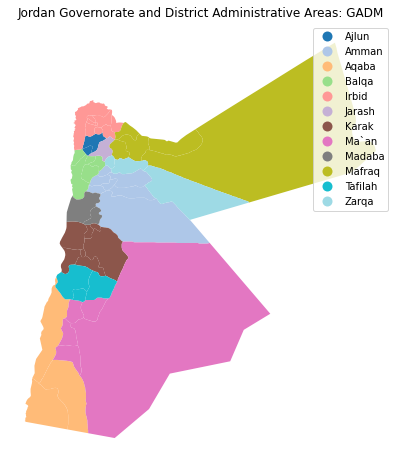

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

# column='Population' identifies which column to use in coloring the points
gadm_admin.plot(ax=ax, column='NAME_1',legend=True,cmap='tab20')
ax.axis('off')
ax.set_title('Jordan Governorate and District Administrative Areas: GADM')
plt.show()

 This will work well for our purposes for any country, though with the limitation that the file must be manually downloaded and stored. For an option which we can ingest straight into Python, we can also consider the FAO GAUL 2015 areas.  
  
#### FAO GAUL 2015
  
FAO GAUL is another source of administrative areas, though these are not available for every country. For information on the countries and administrative levels provided by GAUL 2015, download the GAUL2015_Documentation.zip from the [GAUL Catalog Page](https://data.apps.fao.org/map/catalog/srv/eng/catalog.search#/metadata/9c35ba10-5649-41c8-bdfc-eb78e9e65654). _WhatsNewGAUL2015.pdf_ contains a table of all countries identifying which countries and administrative levels are available.

 If the countries you need are present in the FAO GAUL data, they can be downloaded using Google Earth Engine and then converted to a GeoDataFrame so they match the formatting of our population and wealth data. (For more information on converting between `geemap` and `geopandas`, see this [documentation](https://geemap.org/notebooks/geopandas/)). Google Earth Engine stores the FAO GAUL 2015 data as a [FeatureCollection](https://developers.google.com/earth-engine/guides/feature_collections?hl=en). A `FeatureCollection` is a group of multiple [Features](https://developers.google.com/earth-engine/guides/features?hl=en), which are geometric objects and their related properties. We'll use the data with level 2 administrative areas, which are the most granular available for FAO GAUL in Google Earth Engine. The GEE page for these data can be found [here](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2).  
  
Each time we use the GEE API, we'll need to Initialize our connection. The first time you run this code, you'll need to Authenticate using the authentication code you're provided when you are granted GEE access. For more detailed instruction, see this [Introduction to Google Earth Engine](https://worldbank.github.io/OpenNightLights/tutorials/mod2_4_introduction_to_GEE.html) in the World Bank's Nighttime Lights tutorial.  

In [14]:
import geemap, ee

# Initialize or Authenticate GEE connection
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# Obtain Jordan's level 2 admin data and convert to GeoDataFrame
jordan_admin = geemap.ee_to_geopandas(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM0_NAME', 'Jordan')))
jordan_admin.set_crs(4326, inplace=True)
jordan_admin.head()

,geometry,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,ADM2_CODE,ADM2_NAME,DISP_AREA,EXP2_YEAR,STATUS,STR2_YEAR,Shape_Area,Shape_Leng
0,"POLYGON ((35.59864 32.30641, 35.59948 32.29984...",130,Jordan,1701,Ajloon,65716,Ajloon,NO,3000,Member State,2001,0.032220,1.092534
1,"POLYGON ((35.03999 29.78441, 35.04312 29.78150...",130,Jordan,1703,Aqaba,65718,Wadi Araba,NO,3000,Member State,2001,0.217634,2.638096
2,"POLYGON ((35.59573 31.98709, 35.60333 31.99011...",130,Jordan,1702,Balqa,65722,Al-Salt,NO,3000,Member State,2001,0.018047,0.649854
3,"POLYGON ((35.70837 32.61929, 35.71080 32.61822...",130,Jordan,1707,Irbid,65740,Irbid,NO,3000,Member State,2001,0.023197,0.840361
4,"POLYGON ((35.69533 31.29930, 35.69598 31.29446...",130,Jordan,1704,Karak,65724,Al-Qaser,NO,3000,Member State,2001,0.021907,0.734975


We can plot these administrative areas to confirm the data we've collected.  

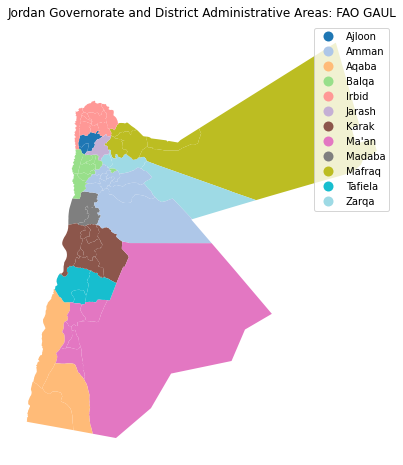

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

# column='Population' identifies which column to use in coloring the points
jordan_admin.plot(ax=ax, column='ADM1_NAME',legend=True,cmap='tab20')
ax.axis('off')
ax.set_title('Jordan Governorate and District Administrative Areas: FAO GAUL')
plt.show()

The above map is colored by level 1 administrative areas (Governorates), with the level 2 areas (Districts) deliniated by white boundaries within each colored area. For policymakers or NGOs, different levels of administrative units may be useful depending on the circumstances, so we will demonstrate creating population-weighted wealth estimates for each available administrative area.  
  
### Plot Population and RWI by Admin Area  
  
Before we move on to creating our population-weighted wealth maps, a final task which may be useful is to create maps of population or wealth on their own. We can do this by performing an `.sjoin()`, which joins two dataframes that overlap in space - for our examples, it will associate all population or wealth locations which fall within a given administrative area to those areas, and we can then aggregate by our chosen area. We can demonstrate at the District level:

In [8]:
# join all population records to their associated admin area
district_pop = gpd.sjoin(pop, jordan_admin.loc[:,('ADM2_NAME','geometry')], op='within', how='right')
# summarize dataset by admin area, taking the mean population for each
district_pop_gb = district_pop.groupby('ADM2_NAME').mean().reset_index()
# add the geometry back into the summarized data
district_pop_gb = district_pop_gb.merge(jordan_admin.loc[:,('ADM2_NAME','geometry')], on='ADM2_NAME')
# view the first 5 rows
district_pop_gb.head()

,ADM2_NAME,index_left,Lat,Lon,Population,geometry
0,Ail,276131.604677,30.068894,35.494057,3.653675,"POLYGON ((35.31635 29.97787, 35.32536 29.97534..."
1,Ajloon,517203.001791,32.350488,35.763963,9.638121,"POLYGON ((35.59864 32.30641, 35.59948 32.29984..."
2,Al-Aghwar Al-Janoobiya,518752.785079,31.136097,35.503990,6.602994,"POLYGON ((35.36691 30.92314, 35.36833 30.92173..."
3,Al-Aghwar Al-Shimaliya,373908.581950,32.576180,35.992499,7.238341,"POLYGON ((35.88516 32.70881, 35.88813 32.70060..."
4,Al-Ardha,415464.500666,31.972914,35.701233,6.309517,"POLYGON ((35.58692 31.97971, 35.58924 31.97237..."


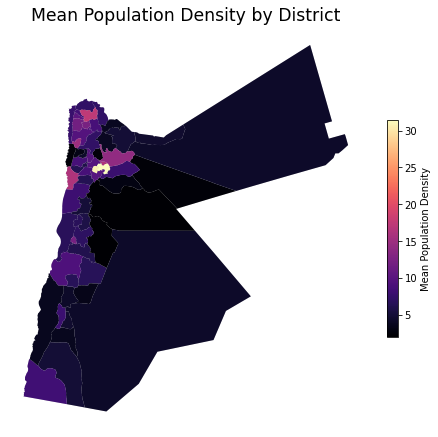

In [75]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
nation = jordan_admin.dissolve(by='ADM0_NAME').reset_index()

# Create the base plots of the entire country for the number of admin level
# maps we want to create
nation.plot(ax=ax, color='lightgrey')
ax.axis('off')
    
# Create each admin level plot of population
district_pop_gb.plot(ax=ax, column='Population', cmap='magma', legend=True, 
                       legend_kwds={'shrink':0.5, 'label':'Mean Population Density'})

ax.set_title('Mean Population Density by District', fontsize='xx-large')

# Save this plot as an image
plt.savefig('jordan_pop_districts.png', dpi=300)
plt.show()

In [11]:
# join all rwi records to their associated admin area
district_rwi = gpd.sjoin(rwi, jordan_admin.loc[:,('ADM2_NAME','geometry')], op='within', how='right')
# summarize dataset by admin area, taking the mean rwi for each
district_rwi_gb = district_rwi.groupby('ADM2_NAME').mean().reset_index()
# add the geometry back into the summarized dataset
district_rwi_gb = district_rwi_gb.merge(jordan_admin.loc[:,('ADM2_NAME','geometry')], on='ADM2_NAME')
# view the first five rows
district_rwi_gb.head()

,ADM2_NAME,index_left,latitude,longitude,rwi,error,geometry
0,Ail,1654.411765,30.042790,35.483901,0.253294,0.501294,"POLYGON ((35.31635 29.97787, 35.32536 29.97534..."
1,Ajloon,1459.133333,32.343695,35.741748,0.372467,0.537987,"POLYGON ((35.59864 32.30641, 35.59948 32.29984..."
2,Al-Aghwar Al-Janoobiya,1239.166667,31.138910,35.504557,-0.112648,0.510667,"POLYGON ((35.36691 30.92314, 35.36833 30.92173..."
3,Al-Aghwar Al-Shimaliya,1399.212121,32.576247,35.995872,0.243606,0.509167,"POLYGON ((35.88516 32.70881, 35.88813 32.70060..."
4,Al-Ardha,1333.071429,31.956155,35.693011,0.182571,0.500571,"POLYGON ((35.58692 31.97971, 35.58924 31.97237..."


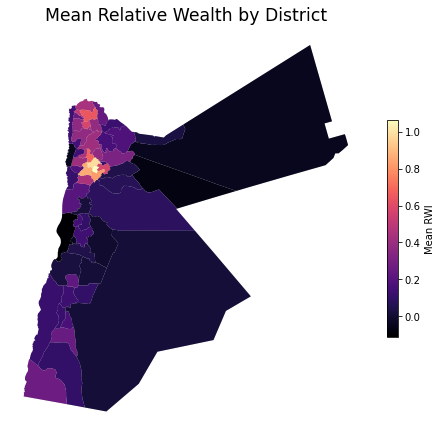

In [76]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
nation = jordan_admin.dissolve(by='ADM0_NAME').reset_index()

# Create the base plots of the entire country for the number of admin level
# maps we want to create
nation.plot(ax=ax, color='lightgrey')
ax.axis('off')
    
# Create each admin level plot of RWI
district_rwi_gb.plot(ax=ax, column='rwi', cmap='magma', legend=True, 
                       legend_kwds={'shrink':0.5, 'label':'Mean RWI'})

ax.set_title('Mean Relative Wealth by District', fontsize='xx-large')

# Save this plot as an image
plt.savefig('jordan_rwi_districts.png', dpi=300)
plt.show()

 ## Create Population-Weighted Wealth Maps
  
Since our population and wealth data are both provided as point locations, we won't be able to directly join these datasets by location. (To do so would require that each point which is provided for the population data exist in the wealth data, which is unlikely given the different sources we use.) Instead, we can use a k-d tree, as demonstrated in [this stackexchange post](https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe) which will allow us to combine these data by matching each point in the population data to the nearest point in the wealth data. We'll implement [KD Tree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html#scipy.spatial.KDTree) from the `scipy` package, which provides this functionality of finding the nearest neighbor(s) for any point. If you haven't worked with `scipy` yet, you can install this package for use according to the [Getting Started instructions](https://docs.scipy.org/doc/scipy/getting_started.html). For these calculations, we'll also need to use `numpy`, a popular package for numerical operations in Python. To install numpy, see the [Installation guide](https://numpy.org/install/) in the documentation.  

In [13]:
from scipy.spatial import KDTree
from shapely.geometry import Point
import numpy as np 

# Define function to find nearest neighbor and join population and wealth datasets accordingly
def ckdnearest(gdA, gdB):
    # create arrays from each dataset to use in k-d trees
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    # create k-d tree from dataset b
    btree = KDTree(nB)
    # find the nearest point in dataset b to each point in dataset a
    dist, idx = btree.query(nA, k=1)
    # select the nearest points in b identified in the row above
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    # join the nearest points from a and b as a geodataframe
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [14]:
# Join according to nearest neighbor using function defined above
overlay = ckdnearest(pop, rwi)
# Clarify column names
overlay.columns = ['longitude_pop', 'latitude_pop', 'pop', 'geometry', 
                   'latitude_rwi', 'longitude_rwi', 'rwi', 'error', 'dist']

# Sum population densities for each location where relative wealth is provided
overlay = overlay.groupby(['latitude_rwi', 'longitude_rwi', 'rwi'], as_index=False)\
    .agg('sum')
# Clarify column names
overlay = overlay[['latitude_rwi', 'longitude_rwi', 'pop', 'rwi']]\
    .rename({'pop':'pop_weight'}, axis=1)
# Scale relative wealth by population to create weighted relative wealth
overlay['weighted_rwi'] = overlay['pop_weight']*overlay['rwi']

# Convert joined dataset to GeoDataFrame
overlay = gpd.GeoDataFrame(overlay, geometry=gpd.points_from_xy(overlay['longitude_rwi'], 
                                                                overlay['latitude_rwi']))
overlay.set_crs(4326,inplace=True)

# Show first 10 rows of dataset
overlay.head(10)

,latitude_rwi,longitude_rwi,pop_weight,rwi,weighted_rwi,geometry
0,29.353451,34.991455,245.844278,0.081,19.913386,POINT (34.99146 29.35345)
1,29.353451,35.035400,106.532520,0.217,23.117557,POINT (35.03540 29.35345)
2,29.353451,35.057373,524.467792,0.637,334.085984,POINT (35.05737 29.35345)
3,29.372601,34.969482,12324.993123,0.976,12029.193288,POINT (34.96948 29.37260)
4,29.372601,34.991455,1524.234522,0.125,190.529315,POINT (34.99146 29.37260)
5,29.391747,34.969482,2237.182927,0.837,1872.522110,POINT (34.96948 29.39175)
6,29.391747,34.991455,1065.325203,0.535,569.948984,POINT (34.99146 29.39175)
7,29.391747,35.035400,106.532520,-0.163,-17.364801,POINT (35.03540 29.39175)
8,29.410890,34.969482,1966.754222,0.748,1471.132158,POINT (34.96948 29.41089)
9,29.410890,34.991455,549.052220,0.482,264.643170,POINT (34.99146 29.41089)


We see once we've joined according to nearest neighbor and created our weighted relative wealth measure, we're left with a dataset which still provides these weighted wealth measures by individual point locations. If this level of granularity is desired, a user can stop the process at this point and will be able to map this data as individual locations, as we've done above.  

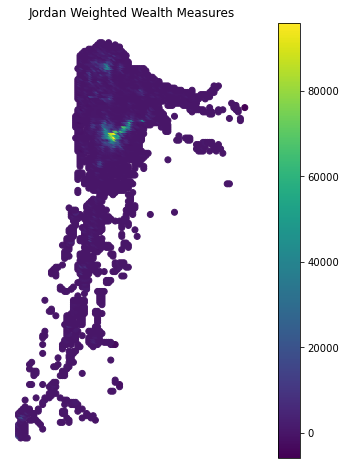

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# column='Population' identifies which column to use in coloring the points
overlay.plot(ax=ax, column='weighted_rwi',legend=True)
ax.axis('off')
ax.set_title('Jordan Weighted Wealth Measures')
plt.show()

However, for use in research or policy decisions, it will often be helpful to have these measures provided at the level of administrative units. We'll aggregate each administrative layer of interest separately, so the code below should be changed according to how many layers the dataset you're using provides and which layers are of interest. For our example, with 2 layers of administrative units, we'll ensure we have dataframes representing the geographic areas of each of our two layers. Since the data we downloaded were already at level 2 granularity, we'll only need to create the level 1 dataframe using `.dissolve()`. Dissolving by 'ADM1_NAME' will give us a dataframe at the admin level 1 granularity ('Governorates' in Jordan). If you have 3 or more admin levels, you can create additional dataframes with this same technique, each time dissolving by the admin level of interest. Once you have all necessary admin level dataframes, you can use the script below to add population-weighted wealth measures to each administrative level.

In [15]:
# Roll up full level 2 admin data to level 1 for processing 
# (if more than 2 admin levels, do this for each level above the lowest)
governorates = jordan_admin.dissolve(by='ADM1_NAME').reset_index()

maps = {}
# For each administrative level dataset, provide the name of the administrative unit layers 
# (ie, divisions, districts, counties, etc), the column name for the unique layer identifier 
# in your dataset, the column name for the unique layer in your dataset, and the name of the dataframe
for name, numberkey, namekey, df in [('governorates', 'ADM1_CODE', 'ADM1_NAME', governorates),
                                     ('districts', 'ADM2_CODE', 'ADM2_NAME', jordan_admin)]:
    
    # Join datasets so admin units are matched with the wealth measure points within unit boundaries
    grouped = gpd.sjoin(overlay, df, op='within', how='right')
    # Sum all wealth and population measures by administrative unit
    grouped = grouped.groupby(numberkey, as_index=False).agg('sum')

    # Create the final population-weighted wealth metric by dividing population value 
    grouped['rwi'] = grouped['weighted_rwi']/grouped['pop_weight']
    # Remove unneeded fields; rename
    grouped = grouped[[numberkey, 'rwi', 'pop_weight']]\
        .rename({'pop_weight':'pop'}, axis=1)
    # Re-join geometric areas for admin units    
    grouped = df[[numberkey, namekey, 'geometry']].merge(grouped, how='left', 
                                                         on=numberkey)
    
    # Identify any admin units which had no associated wealth data
    nulls = grouped[pd.isnull(grouped['rwi'])].copy()
    nonnulls = grouped[~pd.isnull(grouped['rwi'])].copy()
    
    # Label unassigned admin units with the mean of surrounding units
    imputed = []
    for index, row in nulls.iterrows():  
        neighbors = nonnulls[nonnulls.geometry.touches(row['geometry'])]
        imputed.append(neighbors['rwi'].mean())
    nulls['rwi'] = imputed

    # Rejoin assigned and estimated admin units
    grouped = pd.concat([nulls, nonnulls])
    maps[name] = grouped

This will give us the `maps` object which contains all of our dataframes. To access a single dataframe, you can use the following code with the name of the desired administrative unit layer. 

In [22]:
maps['governorates'].head()

,ADM1_CODE,ADM1_NAME,geometry,rwi,pop
0,1701,Ajloon,"POLYGON ((35.70369 32.21736, 35.69852 32.21098...",0.571924,2.034861e+05
1,1705,Amman,"POLYGON ((36.57022 31.72390, 36.57620 31.71572...",0.902020,3.107416e+06
2,1703,Aqaba,"POLYGON ((35.51787 29.27050, 35.48292 29.27587...",0.530247,1.589200e+05
3,1702,Balqa,"MULTIPOLYGON (((35.69407 31.89742, 35.69169 31...",0.664370,9.657574e+05
4,1707,Irbid,"POLYGON ((35.75544 32.42284, 35.75291 32.42523...",0.642397,1.467434e+06


We can store these as either geographic or text files containing each administrative layer's population weighted wealth measure. While non-geographic files are easier to view and use in statistical analysis, the geographic files can be used in subsequent geo-analyses and so may also be desirable to store. We'll show examples of storing these as `csv` files and `shapefiles`, but for instructions on the many other formats available, see the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html) and the [GeoPandas documentation](https://geopandas.org/docs/user_guide/io.html).

In [86]:
def store_as_file(df, country, admin_lvl_nm, file_type):
    """
    Store population weighted wealth measures for a given admin level
        as either csv or shp file 
    Inputs:
        df (DataFrame):  dataframe containing data to store
        country (str): string field of country name
        admin_lvl_nm (str): the name of administrative units at the given
            admin level (eg, 'division', 'district')
        file_type (str): file type to store as, either 'csv' or 'shp'
    """

    file_name = "weighted_wealth_" + country + "_" + admin_lvl_nm

    if file_type == 'csv':
        file_name = file_name + ".csv"
        df.to_csv(file_name)
        print('Saved {}'.format(file_name))
    elif file_type == 'shp':
        file_name = file_name + ".shp"
        file_gpf = gpd.GeoDataFrame(df)
        file_gpf.to_file(file_name)
        print('Saved {}'.format(file_name))
    else:
        print('Unknown file_type requested - select either "csv" or "shp"')

In [87]:
# For each admin level and file type desired, save files
for admin_lvl_nm, df in maps.items():
    for file_type in ['csv','shp']:
        store_as_file(df, 'jordan', admin_lvl_nm, file_type)

Saved weighted_wealth_jordan_governorates.csv
Saved weighted_wealth_jordan_governorates.shp
Saved weighted_wealth_jordan_districts.csv
Saved weighted_wealth_jordan_districts.shp


Finally, it may also be desirable to view the administrative areas according to their population weighted wealth measures. We can use the same mapping package, `matplotlib`, which we used above to create a map for each of our two admin unit levels. 

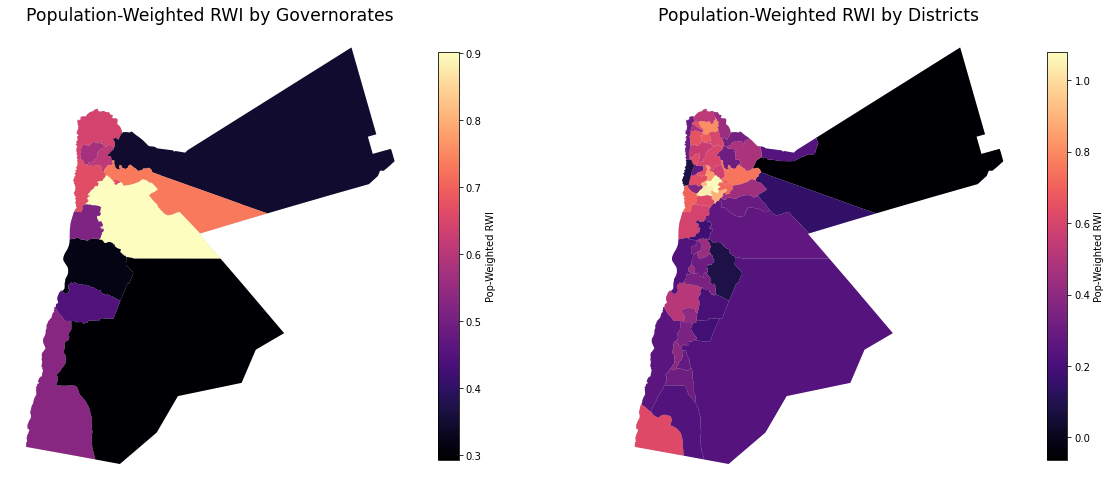

In [79]:
fig, ax = plt.subplots(1,2, figsize=(20,15))
ax = ax.flatten()
nation = jordan_admin.dissolve(by='ADM0_NAME').reset_index()

# Create the base plots of the entire country for the number of admin level
# maps we want to create
for a in range(len(ax)):
    nation.plot(ax=ax[a], color='lightgrey')
    ax[a].axis('off')
    
# Create each admin level plot
maps['governorates'].plot(ax=ax[0], column='rwi', cmap='magma', legend=True, 
                       legend_kwds={'shrink':0.5, 'label':'Pop-Weighted RWI'})
maps['districts'].plot(ax=ax[1], column='rwi', cmap='magma', legend=True, 
                       legend_kwds={'shrink':0.5, 'label':'Pop-Weighted RWI'})

ax[0].set_title('Population-Weighted RWI by Governorates', fontsize='xx-large')
ax[1].set_title('Population-Weighted RWI by Districts', fontsize='xx-large')

# Save this plot as an image
plt.savefig('jordan_wealth_maps.png', dpi=300)
plt.show()

Even with a cursory inspection, we can see the value in viewing our weighted wealth measures by multiple administrative levels. The darker colors represent lower wealth areas, while the lighter colors represent high wealth areas for Jordan. While at the governorate level, the southeast governorate seems to be one of the most in need, upon viewing the map broken down by district, we can see that there are a range of district wealth levels within the poorer governorates, and that in fact the northeast of the country might deserve the greatest initial consideration. Depending on the use case and scale of decisions which need to be made, these can each provide unique value and insight.   
  
## Validation 
  
An important final step in any computational analysis is validating the results. This serves as confirmation of your input data's accuracy if, as in this case, it is derived from alternative methods. Especially importantly, however, it validates your own code and processes. Validation requires some source of true wealth data for your country or region.    
    
One source of wealth data which exists for multiple countries is [The Demographic and Health Surveys (DHS) Program](https://www.dhsprogram.com/), funded by the US Agency for International Development (USAID). The DHS supports surveys in more than 90 countries and makes the data available for research purposes, though you must register your project and be approved to obtain access. While the DHS RWI values are an excellent, comprehensive source, they were also the wealth values used to train Berkeley and Facebook's Relative Wealth Index, which we use as our source of wealth data above. Thus, validating using DHS will not be an independent confirmation of wealth accuracy, but rather a confirmation that our process stays true to the original RWI values.   
  
  
  
While validating our process is helpful, wherever possible it is best to also validate the overall wealth values with a separate source of wealth data. This data may be less available, outdated, or limited in scope (eg, only income or expenditures), but comparing against our population-weighted wealth values can still provide valuable confirmation or indication of concern, depending on how well the values align compared to expectations.    
  
You can check the country's government site or the databases of organizations working in-country for additional sources of survey data. For example, Jordan conducts a [Household Expenditures and Income Survey (HIES)](http://dosweb.dos.gov.jo/economic/expenditures-income/) which we will also use for validation. 

### Demographic and Health Surveys

#### Admin Level 1 DHS (no geocoding)
  
In order to use DHS datasets, you must [register](https://dhsprogram.com/data/new-user-registration.cfm) for each project and dataset you need access to. It can take up to two business days for your registration to be approved, though often this happens more quickly. When registering, provide clear information about your project and your desired use of the DHS data. In our case, it is to validate aggregated wealth maps created through the use of non-traditional sources. Be sure to read the usage conditions for DHS data thoroughly: two components to note in particular are that you should not reuse data from one project without re-registering, and you should provide a copy of your final project to DHS once completed.   
  
You'll receive an email when you've been granted access. You may then login to the DHS site, and you'll be prompted to 'select a Project' in a dropdown.  
  
<img src="img/dhs-select-project.png" width="500" align="center"/>    
  
Select the project name you applied for - for this example, it's 'Geo4Dev Learning Modules', and you'll next be prompted to choose the country whose data you want to use.  
  
<img src="img/dhs-select-country.png" width="500" align="center"/>   
  
After selecting a country, you'll be able to view and select the year of survey data you'd like to use. This should align as closely as possible with the years of the wealth and population data you've incorporated. For this example, we'll take the most recent, 2017-2018. 
  
<img src="img/dhs-select-years.png" width="500" align="center"/>   
  
Finally, you'll download the data. DHS provides its data in multiple formats to make using the data straightforward in Stata, SAS, or SPSS. In Python, we can still easily ingest this data as well, as Pandas provides functionality to read Stata, SAS, and SPSS file types as DataFrames. For this example, we can download the Stata files, which will be provided as a `.zip` folder. I'll download the 'Household Recode' data, which provides survey results at the level of household as opposed to results from individual members of the household, or members by gender and age. This should allow us to most directly compare the weighted wealth estimates we created with the DHS data. For an explanation and information on the different DHS dataset types, see [here](https://www.dhsprogram.com/data/Dataset-Types.cfm).
   
<img src="img/dhs-household-dta.png" width="500" align="center"/>   
  
To access these files, you'll need to unzip the `.zip` file by either right-clicking and selecting 'Extract All' (on Windows) or double-clicking (on MacOS). We can then read this data into Python using Pandas' `.read_stata()` function. Note you'll have to replace the file path used in the example below with the path to the `.dta` file you downloaded. (For more information on the DHS file naming conventions, see [here](https://www.dhsprogram.com/data/File-Types-and-Names.cfm)).

In [17]:
dhs_jordan_household = pd.read_stata('./JO_2017-18_DHS_08192021_1422_166256/JOHR73DT/JOHR73FL.DTA',convert_categoricals=False)
dhs_jordan_household.head()

,hhid,hv000,hv001,hv002,hv003,hv004,hv005,hv006,hv007,hv008,...,hc73_03,hc73_04,hc73_05,hc73_06,hc73_07,hc73_08,hc73_09,hc73_10,hc73_11,hc73_12
0,1 1,JO7,1,1,2,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,JO7,1,2,1,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,JO7,1,3,1,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 4,JO7,1,4,1,1,2241802,11,2017,1415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 5,JO7,1,5,1,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have our dataset, which we can see is very large - depending on your country and survey, the exact size may vary. Some of these are not filled in for our survey, so we'll delete those. 

In [18]:
dhs_jordan_household = dhs_jordan_household.dropna(axis=1,how='all')
dhs_jordan_household.head()

,hhid,hv000,hv001,hv002,hv003,hv004,hv005,hv006,hv007,hv008,...,hc64_09,hc68_01,hc68_02,hc68_03,hc68_04,hc68_05,hc68_06,hc68_07,hc68_08,hc68_09
0,1 1,JO7,1,1,2,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,JO7,1,2,1,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,JO7,1,3,1,1,2241802,10,2017,1414,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 4,JO7,1,4,1,1,2241802,11,2017,1415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 5,JO7,1,5,1,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll select only the columns of interest for us, but first, lets rename the columns to be more user-friendly. DHS provides code to easily rename in Stata, SAS, and SPSS, but since we're working in Python, we'll need to use a bit of a work-around with the Stata `.do` file. We'll take the rows of the `.do` file which are used to 'label variable' and build a mapping table ourselves.  
  
NOTE: I'm selecting only the first 2327 rows of the `.do` file in this example. After this, the `.do` script begins to 'label define' the values in each column, so we only want to select the 'label variable' lines. Depending on the survey and country you select, you should examine the `.do` file first and only select the number of rows which contain 'label variable' commands. 

In [19]:
stata_do = pd.read_table('./JO_2017-18_DHS_08192021_1422_166256/JOHR73DT/JOHR73FL.DO',
    # labels are in quotes, so initially split to just separate labels
    sep='"',
    # indicate there are no meaningful column names
    header=None,
    # add in temporary column names
    names=('to_split','label','unnamed'),
    # skip the first row (a stata infix command we don't need)
    skiprows=1,
    # only take the first 2327 rows of the do file - the rest define the possible values for each field
    nrows=2327)
stata_do.head()

,to_split,label,unnamed
0,label variable hhid,Case Identification,NaN
1,label variable hv000,Country code and phase,NaN
2,label variable hv001,Cluster number,NaN
3,label variable hv002,Household number,NaN
4,label variable hv003,Respondent's line number (answering Household ...,NaN


Now, we see the 'label' column contains the user-friendly names, while the final term in the 'to_split' column contains the column codes we'd like to replace. We can separate these into their own columns to be able to easily map code to label.

In [20]:
stata_do[['na1','na2','code']] = stata_do['to_split'].str.split(expand=True)
stata_do.head()

,to_split,label,unnamed,na1,na2,code
0,label variable hhid,Case Identification,NaN,label,variable,hhid
1,label variable hv000,Country code and phase,NaN,label,variable,hv000
2,label variable hv001,Cluster number,NaN,label,variable,hv001
3,label variable hv002,Household number,NaN,label,variable,hv002
4,label variable hv003,Respondent's line number (answering Household ...,NaN,label,variable,hv003


We'll now take only the code and label columns and use them to create a Python **dictionary**. A dictionary is a way to store data in key-value pairs (the codes as the **keys** mapped to labels as the **values**), and it will enable us to rename the columns of our DataFrame. 

In [21]:
rename_dict = dict(zip(stata_do['code'],stata_do['label']))
dhs_jordan_household = dhs_jordan_household.rename(columns=rename_dict)
dhs_jordan_household.head()

,Case Identification,Country code and phase,Cluster number,Household number,Respondent's line number (answering Household questionnaire),Ultimate area unit,Household sample weight (6 decimals),Month of interview,Year of interview,Date of interview (CMC),...,Birth order number,Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report),Mother's highest educational level (for preliminary and final report)
0,1 1,JO7,1,1,2,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,JO7,1,2,1,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,JO7,1,3,1,1,2241802,10,2017,1414,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 4,JO7,1,4,1,1,2241802,11,2017,1415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 5,JO7,1,5,1,1,2241802,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Excellent, we now have a clearly-named table containing our survey data. We can now select the relevant information to compare with our weighted wealth dataset. From looking at the documentation of this survey, we'll need to use:  
  
"Result of household interview" - to ensure the interview was completed  
"Region"  
"Wealth index combined" 
  
The 'Wealth index combined' field provides the wealth index quintile which the household falls into. According to [The DHS Wealth Index](https://dhsprogram.com/publications/publication-cr6-comparative-reports.cfm) publication report, these quintiles are calculated by creating a weighted frequency distribution comprised of every member of every household, so the population is accounted for. Thus, we can use this field to compare against our population-weighted wealth value directly.

In [22]:
# ensure survey was completed
dhs_jordan_household_wealth = dhs_jordan_household[dhs_jordan_household['Result of household interview']==1]
# select only fields of interest for comparing wealth index values
dhs_jordan_household_wealth = dhs_jordan_household_wealth.loc[:,("Region","Wealth index combined")]
dhs_jordan_household_wealth.head()

,Region,Region,Wealth index combined
0,11,1,4
1,11,1,3
2,11,1,5
3,11,1,5
4,11,1,4


We can see this is just about what we want. The only issue is there are two 'Region' fields: from looking at the documentation, one is the Governorate we're familiar with, while the other is an indicator for North, South, or Central. Lets rename these for clarity.

In [32]:
dhs_jordan_household_wealth.columns = ['Governorate_ID','Region','Wealth index combined']
dhs_jordan_household_wealth.head()

,Governorate_ID,Region,Wealth index combined
0,11,1,4
1,11,1,3
2,11,1,5
3,11,1,5
4,11,1,4


Now, let's find the mean wealth index for each region. We'll do this using Pandas' `.groupby()` functionality, which allows us to group by a column of interest (in our case, Governorate_ID), and calculate statistics for this column. 

In [67]:
dhs_jordan_household_wealth_gb = dhs_jordan_household_wealth.groupby(by='Governorate_ID').mean().reset_index()
dhs_jordan_household_wealth_gb.head()

,Governorate_ID,Region,Wealth index combined
0,11,1.0,3.476891
1,12,1.0,2.808511
2,13,1.0,2.348156
3,14,1.0,2.320438
4,21,2.0,2.691185


We now have our mean wealth index for each Governorate to compare against our weighted wealth index. The final step we'll take is to add friendly names to identify the Governorates. We'll do this using a mapping of Governorate ID to Governorate name, which can be found in the `.MAP` document downloaded with the DHS data. This mapping is also found at the bottom of the Stata `.do` file we used above.

In [66]:
name_govs = {11:  "Amman",12:  "Balqa",13:  "Zarqa",
    14:  "Madaba",21:  "Irbid",22:  "Mafraq",23:  "Jarash",
    24:  "Aljoon",31:  "Karak",32:  "Tafiela",33:  "Ma'an",
    34:  "Aqaba"}
    
name_govs_df = pd.DataFrame.from_dict(name_govs,orient='index',columns=['Governorate']).reset_index()
name_govs_df.head()

,index,Governorate
0,11,Amman
1,12,Balqa
2,13,Zarqa
3,14,Madaba
4,21,Irbid


In [34]:
dhs_jordan_household_wealth_gb = dhs_jordan_household_wealth_gb.merge(name_govs_df,left_on='Governorate_ID',right_on='index')
dhs_jordan_household_wealth_gb

,Governorate_ID,Region,Wealth index combined,index,Governorate
0,11,1.0,3.476891,11,Amman
1,12,1.0,2.808511,12,Balqa
2,13,1.0,2.348156,13,Zarqa
3,14,1.0,2.320438,14,Madaba
4,21,2.0,2.691185,21,Irbid
5,22,2.0,1.722969,22,Mafraq
6,23,2.0,2.178521,23,Jarash
7,24,2.0,2.408532,24,Aljoon
8,31,3.0,2.690714,31,Karak
9,32,3.0,2.341991,32,Tafiela


Now let's join this to our created wealth indices and create a scatterplot of the DHS wealth index values against our wealth index values at the Governorate level to see how well they align.

In [65]:
validate_dhs = maps['governorates'].merge(dhs_jordan_household_wealth_gb, left_on='ADM1_NAME',right_on='Governorate')
validate_dhs.head()

,ADM1_CODE,ADM1_NAME,geometry,rwi,pop,Governorate_ID,Region,Wealth index combined,index,Governorate
0,1705,Amman,"POLYGON ((36.57022 31.72390, 36.57620 31.71572...",0.902020,3.107416e+06,11,1.0,3.476891,11,Amman
1,1703,Aqaba,"POLYGON ((35.51787 29.27050, 35.48292 29.27587...",0.530247,1.589200e+05,34,3.0,2.839971,34,Aqaba
2,1702,Balqa,"MULTIPOLYGON (((35.69407 31.89742, 35.69169 31...",0.664370,9.657574e+05,12,1.0,2.808511,12,Balqa
3,1707,Irbid,"POLYGON ((35.75544 32.42284, 35.75291 32.42523...",0.642397,1.467434e+06,21,2.0,2.691185,21,Irbid
4,1708,Jarash,"POLYGON ((35.68235 32.19351, 35.68264 32.19029...",0.607955,2.499389e+05,23,2.0,2.178521,23,Jarash


Text(0, 0.5, 'Population-Weighted RWI')

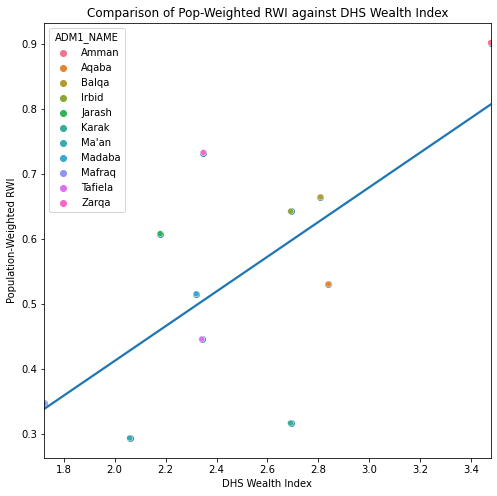

In [92]:
import seaborn as sns

fig, ax1 = plt.subplots(1,1,figsize=(8,8))

sns.regplot(x=validate_dhs['Wealth index combined'],y=validate_dhs['rwi'],ci=False,ax=ax1)
sns.scatterplot(x=validate_dhs['Wealth index combined'],y=validate_dhs['rwi'],hue=validate_dhs['ADM1_NAME'],ax=ax1)
ax1.set_title('Comparison of Pop-Weighted RWI against DHS Wealth Index')
ax1.set_xlabel('DHS Wealth Index')
ax1.set_ylabel('Population-Weighted RWI')

We can see that, at the Governorate level, our population-weighted wealth values roughly align with the DHS wealth index, but there are some outlier districts where our estimate is either far below or slightly above DHS.  
  
#### Geocoded DHS

For a stronger comparison, we can perform this same analysis at the District (Admin Level 2) level. To do this, you'll need to request DHS **GPS** data, which requires additional justification. This data is provided at the level of **clusters**, which are groupings of households in a relatively small geographic radius. The cluster of each household was provided in our original `dhs_jordan_household` dataset above, so when we have the geographic coordinates of each cluster, we can assign each cluster its appropriate District and find the mean relative wealth index for all associated households.  
  
NOTE: The DHS GPS locations ares __displaced__ from their original values by up to 5 km. This is to ensure annonymity of the survey participants, but it means that precise location calculations with this dataset will **not be accurate**. While it will work well for our purposes, as the displacement is restricted to within admin level 2 boundaries, this displacement is important to be aware of prior to attempting use for any other functions. For more, see the [DHS GPS Data Collection page](https://www.dhsprogram.com/methodology/GPS-Data-Collection.cfm). 
  
Once your request is approved, you can select and download the shapefiles for your country as you did for the non-geocoded DHS data. We'll bring these data into Python with GeoPandas' `read_file()`:

In [69]:
dhs_jordan_geo = gpd.read_file('./JO_2017-18_DHS_08242021_055_166256/JOGE71FL/JOGE71FL.shp')
dhs_jordan_geo.head()

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,JO201700000001,JO,2017.0,1.0,JO,NULL,NULL,NULL,NULL,11.0,...,11.0,Amman,GPS,U,31.980907,35.910510,9999.0,909.0,WGS84,POINT (35.91051 31.98091)
1,JO201700000002,JO,2017.0,2.0,JO,NULL,NULL,NULL,NULL,11.0,...,11.0,Amman,GPS,U,31.975399,35.896461,9999.0,950.0,WGS84,POINT (35.89646 31.97540)
2,JO201700000003,JO,2017.0,3.0,JO,NULL,NULL,NULL,NULL,11.0,...,11.0,Amman,GPS,U,31.957432,35.901973,9999.0,855.0,WGS84,POINT (35.90197 31.95743)
3,JO201700000004,JO,2017.0,4.0,JO,NULL,NULL,NULL,NULL,11.0,...,11.0,Amman,GPS,U,31.973120,35.918679,9999.0,899.0,WGS84,POINT (35.91868 31.97312)
4,JO201700000005,JO,2017.0,5.0,JO,NULL,NULL,NULL,NULL,11.0,...,11.0,Amman,GPS,U,31.956353,35.924025,9999.0,880.0,WGS84,POINT (35.92403 31.95635)


We'll only need a few of these fields: the Cluster (DHSCLUST) to join back to our standard DHS data with the wealth index and the geometry to correctly assign each cluster to a District. We can select only these to make things clearer.

In [50]:
dhs_jordan_geo_simp = dhs_jordan_geo.loc[:,('DHSCLUST','geometry')]

In [48]:
# select cluster number and wealth index from non-geocoded DHS data used in section above
dhs_jor_cluster = dhs_jordan_household.loc[:,('Cluster number','Wealth index combined')].groupby('Cluster number').mean().reset_index()
dhs_jor_cluster

,Cluster number,Wealth index combined
0,1,4.650000
1,2,4.000000
2,3,3.750000
3,4,3.500000
4,5,2.750000
...,...,...
965,966,2.000000
966,967,1.263158
967,968,2.200000
968,969,2.150000


In [51]:
# join geocoded DHS records with DHS survey values on cluster number
dhs_jordan_geo_wi = dhs_jordan_geo_simp.merge(dhs_jor_cluster,left_on='DHSCLUST',right_on='Cluster number')
dhs_jordan_geo_wi.head()

,DHSCLUST,geometry,Cluster number,Wealth index combined
0,1.0,POINT (35.91051 31.98091),1,4.65
1,2.0,POINT (35.89646 31.97540),2,4.00
2,3.0,POINT (35.90197 31.95743),3,3.75
3,4.0,POINT (35.91868 31.97312),4,3.50
4,5.0,POINT (35.92403 31.95635),5,2.75


Now, lets join each of these clusters with our Admin Level 2 data to assign each to a District (Admin Level 2). We can then take the mean of the wealth index to arrive at a value we can use to compare against our population-weighted wealth.

In [58]:
district_dhs = gpd.sjoin(dhs_jordan_geo_wi, jordan_admin.loc[:,('ADM2_NAME','geometry')], op='within', how='right')
# summarize dataset by admin area, taking the mean wealth index for each
district_dhs_gb = district_dhs.groupby('ADM2_NAME').mean().reset_index()
# view the first 5 rows
district_dhs_gb.head()


,ADM2_NAME,index_left,DHSCLUST,Cluster number,Wealth index combined
0,Ail,863.428571,864.428571,864.428571,1.342982
1,Ajloon,642.963636,643.963636,643.963636,2.449250
2,Al-Aghwar Al-Janoobiya,746.444444,747.444444,747.444444,1.994444
3,Al-Aghwar Al-Shimaliya,407.500000,408.500000,408.500000,2.397198
4,Al-Ardha,NaN,NaN,NaN,NaN


In [59]:
district_dhs_val = maps['districts'].merge(district_dhs_gb,on='ADM2_NAME')
district_dhs_val.head()

,ADM2_CODE,ADM2_NAME,geometry,rwi,pop,index_left,DHSCLUST,Cluster number,Wealth index combined
0,65716,Ajloon,"POLYGON ((35.59864 32.30641, 35.59948 32.29984...",0.557053,160044.507860,642.963636,643.963636,643.963636,2.449250
1,65718,Wadi Araba,"POLYGON ((35.03999 29.78441, 35.04312 29.78150...",0.254556,7426.015194,956.500000,957.500000,957.500000,1.387500
2,65722,Al-Salt,"POLYGON ((35.59573 31.98709, 35.60333 31.99011...",0.640925,124581.522892,131.631579,132.631579,132.631579,3.448840
3,65740,Irbid,"POLYGON ((35.70837 32.61929, 35.71080 32.61822...",0.811595,581782.593036,383.400000,384.400000,384.400000,2.947373
4,65724,Al-Qaser,"POLYGON ((35.69533 31.29930, 35.69598 31.29446...",0.439920,30620.383179,737.500000,738.500000,738.500000,2.725058


Text(0, 0.5, 'Population-Weighted RWI')

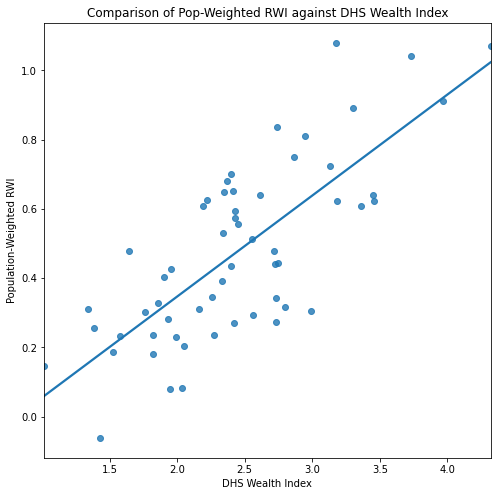

In [91]:
import seaborn as sns

fig, ax1 = plt.subplots(1,1,figsize=(8,8))

sns.regplot(x=district_dhs_val['Wealth index combined'],y=district_dhs_val['rwi'],ci=False,ax=ax1)
ax1.set_title('Comparison of Pop-Weighted RWI against DHS Wealth Index')
ax1.set_xlabel('DHS Wealth Index')
ax1.set_ylabel('Population-Weighted RWI')

As a final visual comparison, we can look at maps of our population-weighted wealth and the DHS relative wealth index to see how well their trends align.

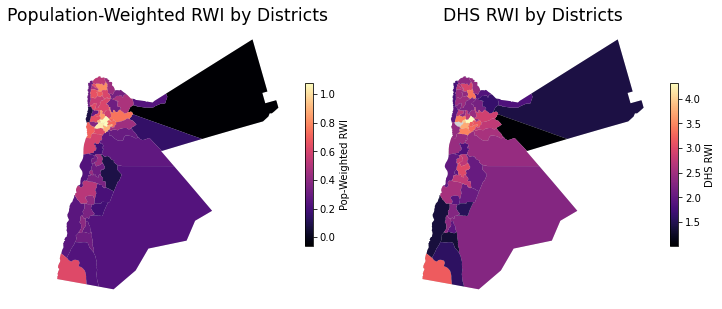

In [90]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax = ax.flatten()
nation = jordan_admin.dissolve(by='ADM0_NAME').reset_index()

# Create the base plots of the entire country for the number of admin level
# maps we want to create
for a in range(len(ax)):
    nation.plot(ax=ax[a], color='lightgrey')
    ax[a].axis('off')
    
# Create each admin level plot
district_dhs_val.plot(ax=ax[0], column='rwi', cmap='magma', legend=True, 
                       legend_kwds={'shrink':0.5, 'label':'Pop-Weighted RWI'})
district_dhs_val.plot(ax=ax[1], column='Wealth index combined', cmap='magma', legend=True, 
                       legend_kwds={'shrink':0.5, 'label':'DHS RWI'})

ax[0].set_title('Population-Weighted RWI by Districts', fontsize='xx-large')
ax[1].set_title('DHS RWI by Districts', fontsize='xx-large')

plt.show()

While the scales are different, we can see that both are very similar in their assignment of relative wealth by district.

### HIES  
  
For another source of validation data, we'll use the Jordanian Household Expenditures and Income Survey. The HIES is available only at the Governorate level, so we will use our Governorate estimates for comparison. Jordan's Department of Statistics provides [multiple datasets describing Households, Expenditures, and Income]((http://dosweb.dos.gov.jo/economic/expenditures-income/expend_tables/)), with the most recent years available at the time of writing being 2017-2018. While measures of Income and Expenditures, which are the values we'll be obtaining from this Survey, are not entirely representative of wealth as it's calculated in our Relative Wealth Index, they are related to RWI. This relation should give us a sense for whether our values are matching expectations or whether something has gone wrong.  
  
I'll use both Average of Annual Current Household Income by Source of Income and Governorate and Urban Rural, Table 3.3, and Average of Annual Household Expenditure on Groups of Commodities and Services by Governorate, Table 4.6. These are available as PDFs, so I'll copy the data into Python and create a DataFrame by Governorate for both Average Income and Average Expenditure. 

In [84]:
hies_2018 = pd.DataFrame({'governorate':['Jarash','Mafraq','Irbid',
    'Madaba','Zarqa','Balqa','Amman','Aqaba',"Ma'an",
    'Tafiela','Karak','Ajlun'],'expenditures':[9815.6,9470.2,11589.4,
    11387.1,11641.5,10232.6,14054.3,9447.8,10155.6,8631.6,10787.8,10771.0],
    'income':[9077.6,9138.7,10432.0,10413.9,9562.6,11450.9,12657.2,10303.3,
    9575.9,10133.2,11755.3,10050.6]})
hies_2018

,governorate,expenditures,income
0,Jarash,9815.6,9077.6
1,Mafraq,9470.2,9138.7
2,Irbid,11589.4,10432.0
3,Madaba,11387.1,10413.9
4,Zarqa,11641.5,9562.6
5,Balqa,10232.6,11450.9
6,Amman,14054.3,12657.2
7,Aqaba,9447.8,10303.3
8,Ma'an,10155.6,9575.9
9,Tafiela,8631.6,10133.2


Now, we can join this HIES average income and expenditure data to our estimates of population-weighted wealth to compare values. However, due to spelling differences in the transliteration of Governorate names from Arabic to English, we'll need to make some adjustments to one of the sets of data to ensure spelling is the same for both. To view which fields are different, we can take another look at the Governorates dataset we generated:

In [73]:
maps['governorates']['ADM1_NAME']

0      Ajloon
1       Amman
2       Aqaba
3       Balqa
4       Irbid
5      Jarash
6       Karak
7       Ma'an
8      Madaba
9      Mafraq
10    Tafiela
11      Zarqa
Name: ADM1_NAME, dtype: object

I'll adjust the HIES dataset to match the administrative area spelling used in our dataset.

In [85]:
# define new 'governorate_adj' field to store the adjusted names
hies_2018['ADM1_NAME'] = hies_2018['governorate']
# rename 'Ajlun' to 'Ajloon'
hies_2018['ADM1_NAME'] = np.where(hies_2018['governorate']=='Ajlun',\
    'Ajloon',hies_2018['ADM1_NAME'])
hies_2018

,governorate,expenditures,income,ADM1_NAME
0,Jarash,9815.6,9077.6,Jarash
1,Mafraq,9470.2,9138.7,Mafraq
2,Irbid,11589.4,10432.0,Irbid
3,Madaba,11387.1,10413.9,Madaba
4,Zarqa,11641.5,9562.6,Zarqa
5,Balqa,10232.6,11450.9,Balqa
6,Amman,14054.3,12657.2,Amman
7,Aqaba,9447.8,10303.3,Aqaba
8,Ma'an,10155.6,9575.9,Ma'an
9,Tafiela,8631.6,10133.2,Tafiela


Now, we can join these datasets by governorate name:

In [86]:
validate_hies = maps['governorates'].merge(hies_2018, on='ADM1_NAME')

Finally, we can create scatterplots to visualize the relationship between our population-weighted wealth index values and the HIES survey data. We should expect them to display similar trends if we've accurately created our population-weighted values. Note, though, that since the expenditure and income data is in Jordanian Dinars while our relative wealth index is on a scale from 0 to 1, the scales of our plots will differ. 

Text(0, 0.5, 'Population-Weighted RWI')

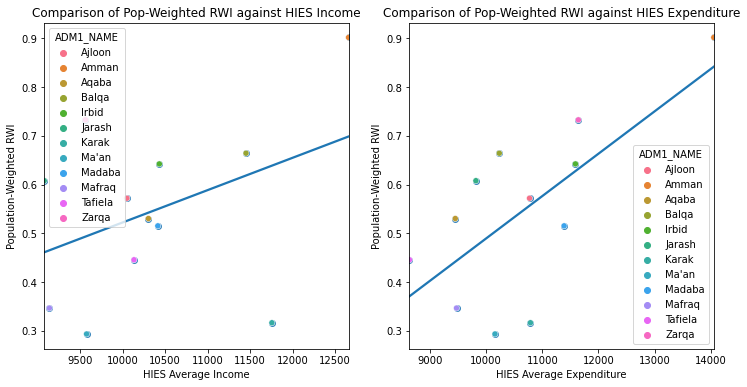

In [93]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

sns.regplot(x=validate_hies['income'],y=validate_hies['rwi'],ci=False,ax=ax1)
sns.scatterplot(x=validate_hies['income'],y=validate_hies['rwi'],hue=validate_hies['ADM1_NAME'],ax=ax1)
ax1.set_title('Comparison of Pop-Weighted RWI against HIES Income')
ax1.set_xlabel('HIES Average Income')
ax1.set_ylabel('Population-Weighted RWI')

sns.regplot(x=validate_hies['expenditures'],y=validate_hies['rwi'],ci=False,ax=ax2)
sns.scatterplot(x=validate_hies['expenditures'],y=validate_hies['rwi'],hue=validate_hies['ADM1_NAME'],ax=ax2)
ax2.set_title('Comparison of Pop-Weighted RWI against HIES Expenditure')
ax2.set_xlabel('HIES Average Expenditure')
ax2.set_ylabel('Population-Weighted RWI')


From a consideration of these plots, we can see that the weighted RWI corresponds better to the Expenditures values than the Income values, though neither are extremely aligned. Since we've had to roll up our data to the Governorate level, however, and in particular since we're only looking at values for income and expenditure rather than the more complex RWI (which uses satellite imagery, internet connectivity, topography, and cellular data among other sources), it is not unexpected to lack exact alignment. This demonstrates the importance of validating with multiple sources if possible, as each validation will likely require consideration within its unique context.

## Conclusion

The increasing availability of novel datasets with global coverage present enormous opportunities for evidence-based policymaking where ground-truth data were previously unavailable. By combining estimates which are built using these geographic datasets, such as the population and wealth measures considered above, we can further enhance their accessibility and usefulness for the organizations and individuals working to improve outcomes for these populations.   